Enter type of noise:- 
1.Vertical Noise
2.Horizontal Noise
3.Right Diagonal Noise
4.Left Diagonal Noise



Enter the Value:-  1


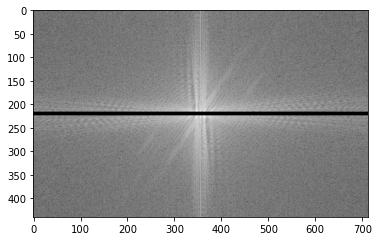

In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import cv2


def distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def butterworthLP(D0, imgShape, n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows / 2, cols / 2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 / (1 + (distance((y, x), center) / D0) ** (2 * n))
    return base


# img = cv.imread(input("Enter Relative Path of Image:-  "), 0)

chessboard_image = cv.imread('/home/khoanvm/CV/data/Chessboard_00451_1.png')

img = cv.cvtColor(chessboard_image, cv.COLOR_BGR2GRAY)

fourier_transform = np.fft.fft2(img)
center_shift = np.fft.fftshift(fourier_transform)

fourier_noisy = 20 * np.log(np.abs(center_shift))

rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

print("Enter type of noise:- \n1.Vertical Noise\n2.Horizontal Noise\n3.Right Diagonal Noise\n4.Left Diagonal Noise\n")
val = int(input("Enter the Value:- "))

if val == 1:
    # horizontal mask
    center_shift[crow - 4:crow + 4, 0:ccol] = 1
    center_shift[crow - 4:crow + 4, ccol:] = 1
    
elif val == 2:
    # vertical mask
    center_shift[:crow, ccol - 4:ccol + 4] = 1
    center_shift[crow:, ccol - 4:ccol + 4] = 1
    
elif val == 3:
    # diagonal-1 mask
    for x in range(0, rows):
        for y in range(0, cols):
            if (x == y):
                for i in range(0, 10):
                    center_shift[x - i, y] = 1
elif val == 4:
    # diagonal-2 mask
    for x in range(0, rows):
        for y in range(0, cols):
            if (x + y == cols):
                for i in range(0, 10):
                    center_shift[x - i - 160, y] = 1

else:
    print("Invalid Input")

filtered = center_shift * butterworthLP(80, img.shape, 10)

f_shift = np.fft.ifftshift(center_shift)
denoised_image = np.fft.ifft2(f_shift)
denoised_image = np.real(denoised_image)

f_ishift_blpf = np.fft.ifftshift(filtered)
denoised_image_blpf = np.fft.ifft2(f_ishift_blpf)
denoised_image_blpf = np.real(denoised_image_blpf)

fourier_noisy_noise_removed = 20 * np.log(np.abs(center_shift))

# fig = plt.figure(figsize=(8, 8))
# ax1 = fig.add_subplot(2, 3, 1)
# ax1.title.set_text("Original Image")
# ax1.imshow(img, cmap='gray')
# ax2 = fig.add_subplot(2, 3, 2)
# ax2.imshow(fourier_noisy, cmap='gray')
# ax2.title.set_text("Fourier Transform")
# ax3 = fig.add_subplot(2, 3, 3)
# ax3.imshow(fourier_noisy_noise_removed, cmap='gray')
# ax3.title.set_text("Fourier Transform with mask")
# ax4 = fig.add_subplot(2, 3, 4)
# ax4.imshow(denoised_image, cmap='gray')
# ax4.title.set_text("Denoised and unfiltered image")
# ax5 = fig.add_subplot(2, 3, 6)
# ax5.imshow(denoised_image_blpf, cmap='gray')
# ax5.title.set_text("Denoised and filtered image")

plt.imshow(fourier_noisy_noise_removed, cmap='gray')
plt.show()

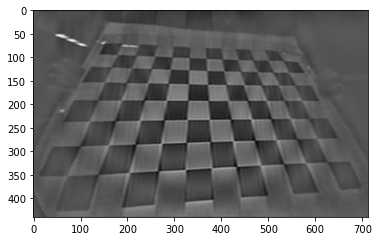

In [8]:
plt.imshow(denoised_image_blpf, cmap='gray')
plt.show()

In [9]:
normalized_image = (denoised_image_blpf-np.min(denoised_image_blpf)) / (np.max(denoised_image_blpf) - np.min(denoised_image_blpf))

In [10]:
normalized_image = np.uint8(255 * normalized_image)

In [11]:
normalized_image

array([[84, 85, 86, ..., 79, 80, 82],
       [82, 84, 86, ..., 74, 76, 79],
       [81, 84, 86, ..., 72, 75, 78],
       ...,
       [92, 90, 88, ..., 96, 95, 93],
       [90, 89, 88, ..., 92, 92, 91],
       [87, 87, 87, ..., 86, 86, 87]], dtype=uint8)

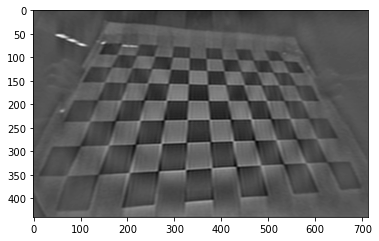

In [12]:
plt.imshow(normalized_image, cmap='gray')
plt.show()

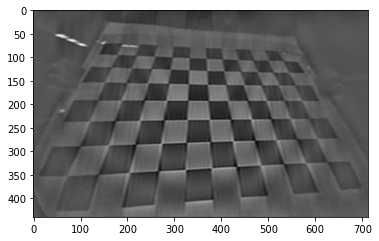

In [163]:
a = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)

plt.imshow(a, cmap='gray')
plt.show()

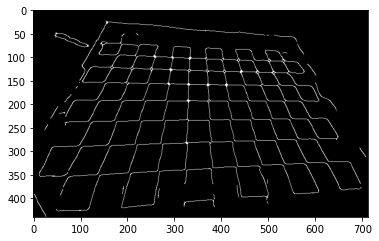

In [14]:
B, G, R = cv2.split(a)
B = cv2.equalizeHist(B)
G = cv2.equalizeHist(G)
R = cv2.equalizeHist(R)
out = cv2.merge((B,G,R))

noiseless_image_colored = cv2.fastNlMeansDenoisingColored(out , None, 20, 20, 8, 21) 

gray = cv2.cvtColor(noiseless_image_colored, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7, 7), 0)

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# perform edge detection
edged = cv2.Canny(blur, 130, 130)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

plt.imshow(edged, cmap='gray')
plt.show()

In [16]:
import imutils
from imutils import perspective
from imutils import contours
import math
from math import exp
from math import sqrt

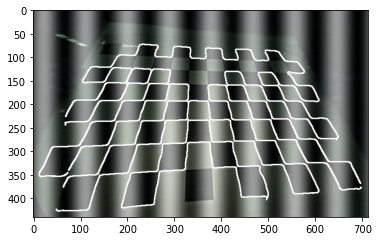

In [17]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
# draw the shape of the contour on the output image, compute the
# bounding box, and display the number of points in the contour
output = chessboard_image.copy()
cv2.drawContours(output, [c], -1, (255, 255, 255), 2)

plt.imshow(output)
plt.show()

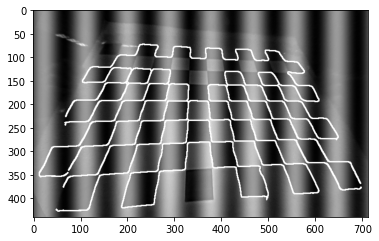

In [18]:
test = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
plt.imshow(test, cmap='gray')
plt.show()

In [19]:
def compute_distance(p, p1, p2):
    x_diff = p2[0] - p1[0]
    y_diff = p2[1] - p1[1]
    num = abs(y_diff * p[0] - x_diff * p[1] + p2[0]*p1[1] - p2[1]*p1[0])
    den = math.sqrt(y_diff**2 + x_diff**2)
    return num * 1.0/ den

In [20]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return math.floor(x), math.floor(y)

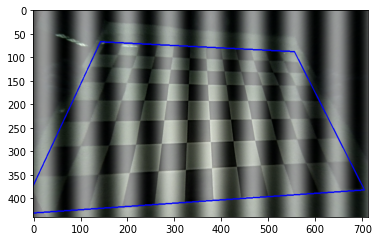

In [38]:
test[np.where(test != 255)] = 0
lines = cv2.HoughLinesP(test.copy(), rho=1, theta=np.pi/180, threshold=80, minLineLength = 150, maxLineGap = 100) # https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a

k = chessboard_image.copy()

horizontal_midpoint = (0, k.shape[1] // 2 - 100)
vertical_midpoint = (k.shape[0] // 2 + 150, 0)

hor_line_list = []
ver_line_list = []
horizontal_list = []
vertical_list = []
list = []

limit = 30

for line in lines:
    x1, y1, x2, y2 = line[0]
    # cv2.line(k, (x1, y1), (x2, y2), (0, 0, 255), 2)
    spl = math.degrees(math.atan2((y1 - y2), (x1 - x2))) % 360
    
    if (not limit < spl <= 360 - limit) or (180 - limit <= spl < 180 + limit):
        hor_line_list.append([(x1, y1), (x2, y2)])
        # cv2.line(k, (x1, y1), (x2, y2), (0, 0, 255), 2)
    elif (90 - limit < spl < 90 + limit) or (270 - limit < spl < 270 + limit):
        ver_line_list.append([(x1, y1), (x2, y2)])
        # cv2.line(k, (x1, y1), (x2, y2), (0, 0, 255), 2)
    

for hor_line in hor_line_list:
    x1, y1 = hor_line[0]
    x2, y2 = hor_line[1]
    horizontal_list.append(compute_distance(vertical_midpoint, (x1, y1), (x2, y2)))
    
for ver_line in ver_line_list:
    x1, y1 = ver_line[0] 
    x2, y2 = ver_line[1]
    vertical_list.append(compute_distance(horizontal_midpoint, (x1, y1), (x2, y2)))


horizontal_list = np.array(horizontal_list)
vertical_list = np.array(vertical_list)
list = np.array(list)

min_ho, max_ho = np.argmin(horizontal_list), np.argmax(horizontal_list)
min_ver, max_ver = np.argmin(vertical_list), np.argmax(vertical_list)

# print(vertical_list)
# print(min_ver)

# cv2.line(k, list[min_ho][0], list[min_ho][1], (0, 0, 255), 2)
# cv2.line(k, list[max_ho][0], list[max_ho][1], (0, 0, 255), 2)
# cv2.line(k, list[min_ver][0], list[min_ver][1], (0, 0, 255), 2)
# cv2.line(k, list[max_ver][0], list[max_ver][1], (0, 0, 255), 2)

a_1 = line_intersection(hor_line_list[min_ho], ver_line_list[min_ver])
b_1 = line_intersection(hor_line_list[min_ho], ver_line_list[max_ver])
c_1 = line_intersection(hor_line_list[max_ho], ver_line_list[min_ver])
d_1 = line_intersection(hor_line_list[max_ho], ver_line_list[max_ver])

cv2.line(k, a_1, b_1, (0, 0, 255), 2)
cv2.line(k, c_1, d_1, (0, 0, 255), 2)
cv2.line(k, b_1, d_1, (0, 0, 255), 2)
cv2.line(k, a_1, c_1, (0, 0, 255), 2)

plt.imshow(k)
plt.show()

In [155]:
chessboard_image = cv2.imread('/home/khoanvm/CV/data/Chessboard_00451_1.png')

B, G, R = cv2.split(chessboard_image)
B = cv2.equalizeHist(B)
G = cv2.equalizeHist(G)
R = cv2.equalizeHist(R)
out = cv2.merge((B,G,R))

noiseless_image_colored = cv2.fastNlMeansDenoisingColored(out , None, 20, 20, 8, 21) 

gray = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# perform edge detection
edged = cv2.Canny(thresh, 70, 100)
edged = cv2.dilate(edged, None, iterations=2)
edged = cv2.erode(edged, None, iterations=1)

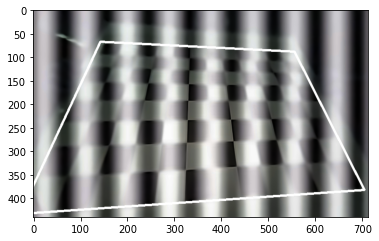

In [156]:
image = noiseless_image_colored
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7, 7), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Remove noise with morph operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
invert = 255 - opening

# Find contours and find squares with contour area filtering + shape approximation
cnts = cv2.findContours(invert, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if area > 100 and area < 10000:
    x,y,w,h = cv2.boundingRect(c)
    # cv2.drawContours(original, [c], -1, (255,255,255), 3)

cv2.line(original, a_1, b_1, (255, 255, 255), 3)
cv2.line(original, c_1, d_1, (255, 255, 255), 3)
cv2.line(original, b_1, d_1, (255, 255, 255), 3)
cv2.line(original, a_1, c_1, (255, 255, 255), 3)

    
plt.imshow(original, cmap='gray')
plt.show()

(143, 67) (556, 88) (-28, 433) (705, 382)


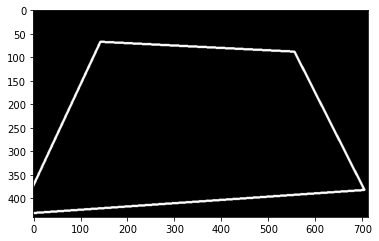

In [157]:
mask = np.zeros((gray.shape), np.uint8)

cv2.line(mask, a_1, b_1, (255, 255, 255), 3)
cv2.line(mask, c_1, d_1, (255, 255, 255), 3)
cv2.line(mask, b_1, d_1, (255, 255, 255), 3)
cv2.line(mask, a_1, c_1, (255, 255, 255), 3)

mask = cv2.rectangle(mask, (0, 0), (mask.shape[1], mask.shape[0]), 255, 1)
print(a_1, b_1, c_1, d_1)

plt.imshow(mask, cmap='gray')
plt.show()

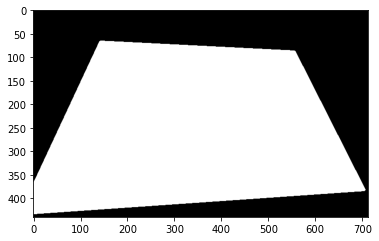

In [158]:
blurred = cv2.GaussianBlur(mask, (7, 7), 0)
value, thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)

cnts, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(mask, [cnts[0]], 0, 255, -1)

plt.imshow(mask, cmap='gray')
plt.show()

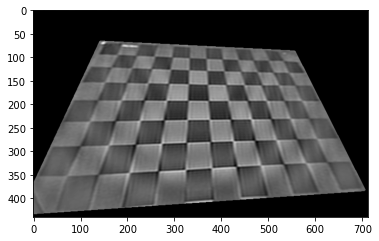

In [167]:
output = np.zeros_like(gray)

output[mask == 255] = normalized_image[mask == 255]

plt.imshow(output, cmap='gray')
plt.show()

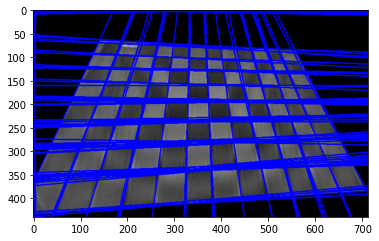

In [215]:
image = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
img = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 50, 50)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# lines_2 = cv2.HoughLinesP(final_gray.copy(), rho=1, theta=np.pi/180, threshold = 100, minLineLength = 200, maxLineGap = 100)
lines_2 = cv2.HoughLines(edged.copy(), rho=1, theta=np.pi/180, threshold=100)

for line in lines_2:
    rho, theta = line[0]
    # x1, y1, x2, y2 = line[0]
    # x = np.asarray([[x1, x2]], dtype = "float64")
    # y = np.asarray([[y1, y2]], dtype = "float64")
    # rho, theta = cv2.cartToPolar(x, y, angleInDegrees=False)
    # print(rho, theta)
    # rho, theta = rho[0][0], theta[0][0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img, (x1, y1), (x2, y2), (0,0,255), 2)

plt.imshow(img, cmap='gray')
plt.show()